# Comparison between udf registration and no udf registration

## Setting up experiment: Data and Function

In [157]:
import random
import pandas as pd

random.seed(42)
num_of_points_per_particle = 50
num_of_particles = 4

random_points_with_particle = {
    'particle_id': [],
    'abscissa_x': [],
    'ordinate_y': []
}

for i in range(num_of_particles):
    for j in range(num_of_points_per_particle):

        random_points_with_particle['particle_id'].append(i)
        
        if i == 0:
            random_points_with_particle['abscissa_x'].append(random.randint(5, 45))
            random_points_with_particle['ordinate_y'].append(random.randint(5, 45))
        
        if i == 1:
            random_points_with_particle['abscissa_x'].append(50 + random.randint(5, 45))
            random_points_with_particle['ordinate_y'].append(random.randint(5, 45))

        if i == 2:
            random_points_with_particle['abscissa_x'].append(random.randint(5, 45))
            random_points_with_particle['ordinate_y'].append(50 + random.randint(5, 45))

        if i == 3:
            random_points_with_particle['abscissa_x'].append(50 + random.randint(5, 45))
            random_points_with_particle['ordinate_y'].append(50 + random.randint(5, 45))

points_df = pd.DataFrame(random_points_with_particle)

points_df.to_csv(f'./text_files/convex_hull_points/points_{num_of_points_per_particle * 4}.csv', index=False, header=False)

In [158]:
def calculate_convex_hull(points):
    import numpy as np
    from scipy.spatial import ConvexHull
    
    points_array = np.array(points)
    hull = ConvexHull(points_array)
    hull_points = points_array[hull.vertices]
    return hull_points.tolist()


## Making sure the Convex Hull algo works properly

In [159]:
from scipy.spatial import convex_hull_plot_2d, ConvexHull
import matplotlib.pyplot as plt
import pandas as pd

data_df = pd.read_csv('./text_files/convex_hull_points/points_200.csv', names=['particle_id', 'x', 'y'])
data_df['point'] = data_df[['x', 'y']].values.tolist()
points_df = data_df.groupby('particle_id').point.apply(list)

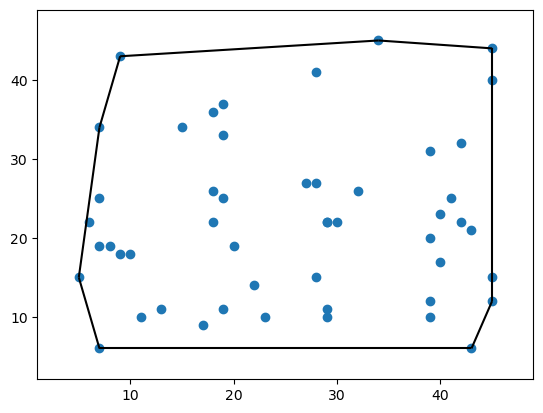

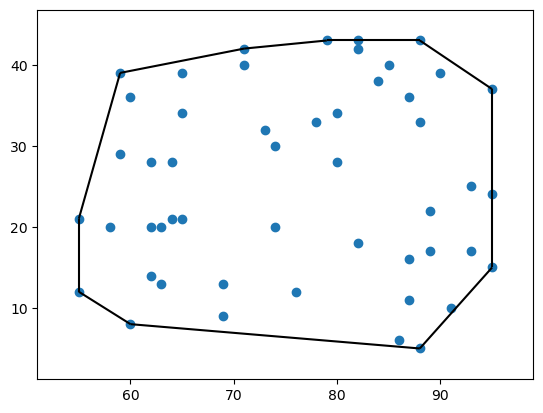

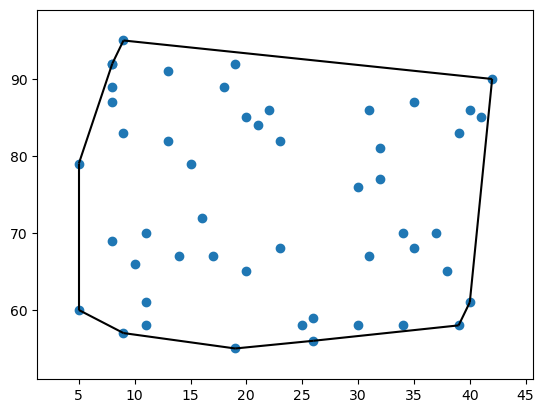

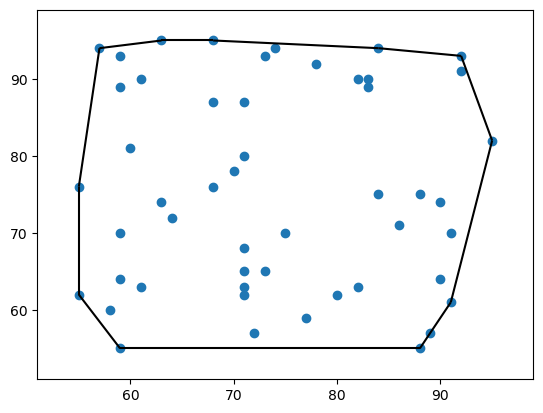

In [160]:
for row in points_df:
    hull = ConvexHull(row)
    _ = convex_hull_plot_2d(hull)

plt.show()

## With UDF registration

In [161]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import udf, collect_list, array

spark_session = SparkSession.builder.master('local[6]').appName('ConvexHull').getOrCreate()

In [162]:
calculate_convex_hull_udf = udf(calculate_convex_hull, ArrayType(ArrayType(IntegerType())))

In [163]:
hull_df = spark_session.read.option('inferSchema', 'true') \
                              .csv('./text_files/convex_hull_points/points_2000000.csv') \
                              .toDF(  
                                'partical_id', 'x', 'y'
                              ) \
                              .withColumn('points', array('x', 'y')) \
                              .groupBy('partical_id').agg(collect_list('points').alias('grouped_points')) \
                              .withColumn('convex_hull', calculate_convex_hull_udf('grouped_points'))


In [164]:
hull_df['partical_id', 'convex_hull'].show(truncate=False)

+-----------+----------------------------------------+
|partical_id|convex_hull                             |
+-----------+----------------------------------------+
|1          |[[55, 45], [55, 5], [95, 5], [95, 45]]  |
|3          |[[55, 95], [55, 55], [95, 55], [95, 95]]|
|2          |[[5, 95], [5, 55], [45, 55], [45, 95]]  |
|0          |[[5, 45], [5, 5], [45, 5], [45, 45]]    |
+-----------+----------------------------------------+



In [165]:
spark_session.stop()

## Without UDF registration

In [166]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, array

spark_session = SparkSession.builder.master('local[6]').appName('ConvexHull').getOrCreate()

In [167]:
points_df = spark_session.read.option('inferSchema', 'true') \
                              .csv('./text_files/convex_hull_points/points_2000000.csv') \
                              .toDF(  
                                'partical_id', 'x', 'y'
                              ) \
                              .withColumn('points', array('x', 'y')) \
                              .groupBy('partical_id').agg(collect_list('points').alias('grouped_points'))

In [168]:
points = points_df.collect()

In [169]:
spark_session.stop()

In [170]:
for row in points:

    result = calculate_convex_hull(row[1])
    print(row[0], result)

1 [[55, 45], [55, 5], [95, 5], [95, 45]]
3 [[55, 95], [55, 55], [95, 55], [95, 95]]
2 [[5, 95], [5, 55], [45, 55], [45, 95]]
0 [[5, 45], [5, 5], [45, 5], [45, 45]]


In [178]:
data = {
    'with_udf': [7.4, 7.1, 6.8, 6.7, 6.7, 6.7, 6.7, 6.7, 6.6, 6.6],
    'without_udf': [4.9, 4.9, 4.6, 4.1, 4.4, 4.6, 4.6, 5.0, 4.6, 4.7]
}
data_df = pd.DataFrame(data=data)

stat_df = pd.DataFrame()
stat_df['Mean'] = data_df.mean()
stat_df['Median'] = data_df.median()
stat_df['Standard Deviation'] = data_df.std()
stat_df = stat_df.round(2)

stat_df

,Mean,Median,Standard Deviation
with_udf,6.80,6.7,0.25
without_udf,4.64,4.6,0.26


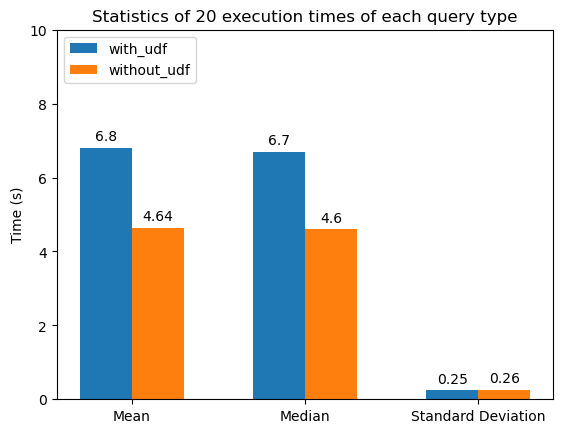

In [182]:
# 7.4 4.9
# 7.1 4.9
# 6.8 4.6
# 6.7 4.1
# 6.7 4.4
# 6.7 4.6
# 6.7 4.6
# 6.7 5.0
# 6.6 4.6
# 6.6 4.7

import numpy as np

stats = stat_df.columns
query_data = stat_df.T

x = np.arange(len(stats))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for key, values in query_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=key)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Statistics of 20 execution times of each query type')
ax.set_xticks(x + 0.5 * width, stats)

ax.legend(loc='upper left')
ax.set_ylim(0, 10)

plt.show()